# Fashion-MNIST Classifier Using ResNet Blocks

In this notebook we attempt to classify images from the Fashion-MNIST data set using convolutional neural networks. We perform close to state of the art performance with validation accuracy in the 93%-94% range.

The structure of the model has been inspired by a [TensorFlow Tutorial](https://adventuresinmachinelearning.com/introduction-resnet-tensorflow-2/)(by Andy Thomas?).

### Table of Contents

- [0. Loading Packages and Data](#0.-Loading-Packages-and-Data)
- [1. Data Preprocessing](#1.-Data-Preprocessing)
- [2. Model Construction](#2.-Model-Construction)
- [3. Model Training](#3.-Model-Training)
- [4. Prediction Visualizations](#4.-Prediction-Visualizations)


## 0. Loading Packages and Data

The convolutional network was built using the Keras API, now officially implemented in TensorFlow.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, callbacks, optimizers

We will also need Numpy for some data processing and Matplotlib for graphs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Since my GPU has a compute capability of 3.0, I have to use version 2.0 of TensorFlow, but the script should work for 2.1 as well.

##### To do: 
Test this in CPU mode version 2.1.

In [3]:
print(tf.__version__)

2.0.0


In [4]:
seed = 0
tf.random.set_seed(seed)

In [5]:
fashion_mnist = datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
len(train_labels)

60000

In [9]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

In [12]:
# add a dimension for convnet compatibility
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 1. Data Preprocessing

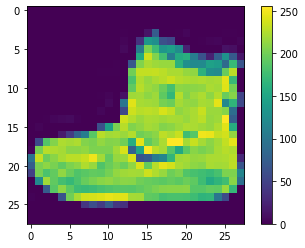

In [13]:
plt.figure()
plt.imshow(train_images[0, :, :, 0])
plt.colorbar()
plt.grid(False)
plt.show()

In [14]:
train_images = train_images / 255.0
test_images = test_images / 255.0

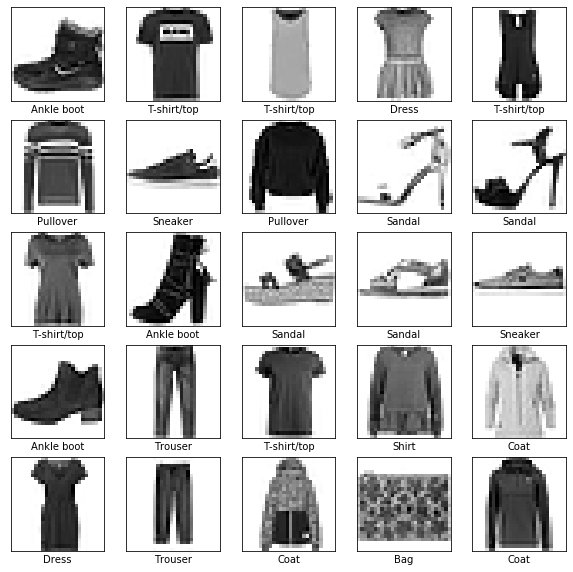

In [15]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i,:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 2. Model construction

In [16]:
l2_coeff = 0.01 # Change to coefficient (Not using it?)
reg_l2 = regularizers.l2(l2_coeff)

**To do:** Make the stride computation adaptative to the input and output sizes

In [32]:
def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

def res_net_block_double(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(filters*2, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    stride = int(round(input_data.shape[1]/x.shape[1]))
    y =  layers.Conv2D(filters*2, (1,1), activation=None, padding='valid', strides=(2,2))(input_data)
    x = layers.Add()([x, y])
    x = layers.Activation('relu')(x)
    return x

In [34]:
inputs = tf.keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation='relu', padding = 'same')(inputs)

x = res_net_block(x, 32, 3)
x = res_net_block_double(x, 64, 3)

x = res_net_block(x, 128, 3)
x = res_net_block_double(x, 128, 3)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation='softmax', 
                      kernel_regularizer=None)(x)

res_net_model = tf.keras.Model(inputs, outputs)

In [35]:
res_net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 28, 28, 32)   320         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_95[0][0]                  
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 28, 28, 32)   128         conv2d_96[0][0]                  
____________________________________________________________________________________________

In [36]:
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# The following is a function that returns the learning rate, to be used as a metric during training
#def get_lr_metric(optimizer):
#    def lr(y_true, y_pred):
#        return optimizer.lr
#    return lr
#
#lr_metric = get_lr_metric(opt)

In [37]:
cbacks = [
                # reduce learning rate by a factor of 5 (i.e. lr/=5.0) 
                # if val_loss does not reduce for 3 epochs
                callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3
                ),
                # Stop training if val_acc does not improve for
                # 5 or more epochs
                callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=10,
                    restore_best_weights=True
                )
            ]

## 3. Model Training

In [38]:
res_net_model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'], callbacks=cbacks)

history = res_net_model.fit(train_images, train_labels, epochs=200, batch_size=32,
                   validation_data=(test_images, test_labels), callbacks = cbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 199s 3ms/sample - loss: 0.3774 - accuracy: 0.8636 - val_loss: 0.3214 - val_accuracy: 0.8794
Epoch 2/200
60000/60000 [==============================] - 196s 3ms/sample - loss: 0.2492 - accuracy: 0.9102 - val_loss: 0.3245 - val_accuracy: 0.8847
Epoch 3/200
60000/60000 [==============================] - 193s 3ms/sample - loss: 0.2131 - accuracy: 0.9239 - val_loss: 0.3631 - val_accuracy: 0.8648
Epoch 4/200
60000/60000 [==============================] - 197s 3ms/sample - loss: 0.1851 - accuracy: 0.9329 - val_loss: 0.2109 - val_accuracy: 0.9249
Epoch 5/200
60000/60000 [==============================] - 194s 3ms/sample - loss: 0.1612 - accuracy: 0.9412 - val_loss: 0.2180 - val_accuracy: 0.9239
Epoch 6/200
60000/60000 [==============================] - 200s 3ms/sample - loss: 0.1420 - accuracy: 0.9488 - val_loss: 0.2410 - val_accuracy: 0.9162
Epoch 7/200
60000/60000 [===================

In [39]:
test_loss, test_acc = res_net_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


10000/1 - 11s - loss: 0.1167 - accuracy: 0.9383

Test accuracy: 0.9383


10000/1 - 11s - loss: 0.1167 - accuracy: 0.9383


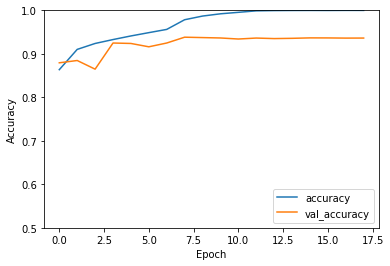

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = res_net_model.evaluate(test_images, test_labels, verbose=2)

## 4. Prediction Visualizations

In [43]:
predictions = res_net_model.predict(test_images)

In [44]:
predictions[0]

array([4.4320925e-07, 2.5231719e-08, 2.1025421e-07, 1.1012835e-06,
       5.3282356e-08, 2.5649297e-05, 5.5023545e-08, 1.5641301e-07,
       4.4380624e-08, 9.9997234e-01], dtype=float32)

In [45]:
np.argmax(predictions[0])

9

In [46]:
test_labels[0]

9

In [47]:
def plot_image(i, predictions_array, true_label, img):
    """
    Shows the image with prediction and predicted label with calculated
    probability.
    """
    predictions_array, true_label, img = predictions_array, true_label[i], \
                                         img[i,:,:,0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    """
    Shows a bar graph of the calculated probabilities.
    """
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


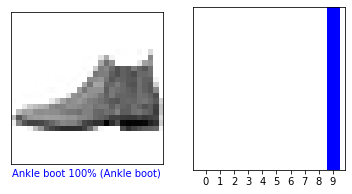

In [48]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


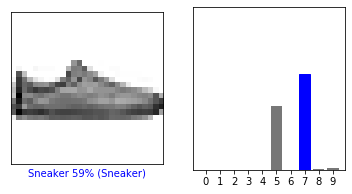

In [49]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


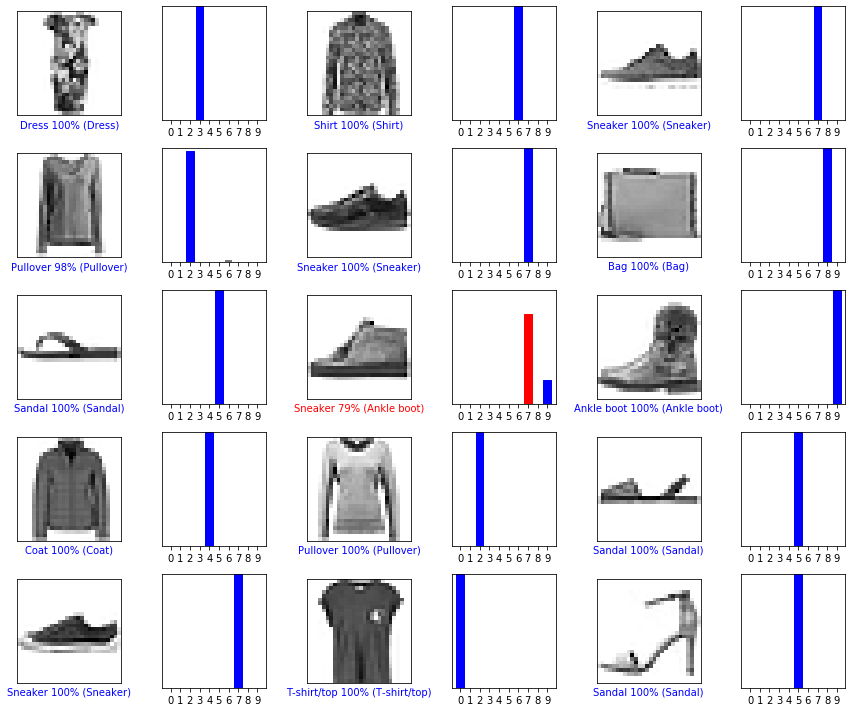

In [50]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
start_image = 100 # Set to 0 for first images
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(start_image + i, predictions[start_image + i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(start_image + i, predictions[start_image + i], test_labels)
plt.tight_layout()
plt.show()
